In [1]:
%matplotlib inline

import sys
sys.path.insert(0,'../../ummon3')  
sys.path.insert(0,'../ummon3')   

import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import load_mnist
from ummon import *

# Some nice default configuration for plots
plt.gray();
plt.rcParams['figure.figsize'] = 17, 12;
plt.rcParams['axes.grid'] = True;

# show a set of images
def plot_gallery(data, shape, interpolation='nearest'):
    for i in range(data.shape[0]):
        plt.subplot(1, data.shape[0], (i + 1));
        plt.imshow(data[i].reshape(shape), interpolation=interpolation);
        plt.xticks(()), plt.yticks(());

<Figure size 432x288 with 0 Axes>

read MNIST data set and scale it

In [2]:
X0,y0,Xv,yv,X1,y1 = load_mnist.read([0,1,2,3,4,5,6,7,8,9], path="")
x2 = (1.0/255.0)*Xv.astype('float32')

MNIST, Classes:     10
Training Images:    (50000, 784)
Validation Images:  (10000, 784)
Test Images:        (10000, 784)


Convolutional network MNIST 3

In [3]:
cnet = Sequential(
    ('unfla', Unflatten([784],          [1,28,28])),
    ('conv0', Conv(     [1,28,28],      [20,5,5], init='xavier_normal_')),
    ('pool0', MaxPool(  [20,24,24],     (2,2), (2,2))),
    ('relu0', nn.ReLU()),
    ('conv1', Conv(     [20,12,12],     [40,5,5], init='xavier_normal_')),
    ('pool1', MaxPool(  [40,8,8],       (2,2), (2,2))),
    ('relu1', nn.ReLU()),
    ('flatt', Flatten(  [40,4,4])),
    ('line0', Linear(   [640],          516, 'xavier_normal_')),
    ('drop0', Dropout(  [516],          0.5)),
    ('relu2', nn.ReLU()),
    ('line1', Linear(   [516],          10, 'xavier_normal_'))
)
print(cnet)

Sequential:
  unfla: Unflatten([1,1,bs,784]->[bs,1,28,28])
  conv0: Conv([bs,1,28,28]->[bs,20,24,24],mask[20,1,5,5],str=(1,1),pad=0,bias=True)
  pool0: MaxPool([bs,20,24,24]->[bs,20,12,12];sz=2,2;str=2,2;pad=0)
  relu0: ReLU()
  conv1: Conv([bs,20,12,12]->[bs,40,8,8],mask[40,20,5,5],str=(1,1),pad=0,bias=True)
  pool1: MaxPool([bs,40,8,8]->[bs,40,4,4];sz=2,2;str=2,2;pad=0)
  relu1: ReLU()
  flatt: Flatten([bs,40,4,4]->[1,1,bs,640])
  line0: Linear([1,1,bs,640]->[1,1,bs,516]), bias=True)
  drop0: Dropout([1,1,bs,516]->[1,1,bs,516];rate=0.5)
  relu2: ReLU()
  line1: Linear([1,1,bs,516]->[1,1,bs,10]), bias=True)
  -
  Number of layers       : 12
  Number of neurons      : 18126
  Number of weights      : 1918006
  Number of adj. weights : 356486



Read in weights from trained network (use mnist_3.py):

In [4]:
trs = Trainingstate()
trs.load_state('mnist_3.pth.tar')
trs.load_weights_(cnet)

## Receptive fields of first convolutional layer

In [5]:
w = cnet.conv0.w
b = cnet.conv0.b
w.shape

(20, 1, 5, 5)

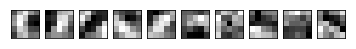

In [6]:
w = np.reshape(w, (20,25))
plot_gallery(w[:10,:], shape=(5, 5))

Get the 9 inputs that activate feature map 0 the most:

In [7]:
vis = Visualizer(cnet)
y = vis.get_max_inputs('conv0', 0, 9, x2)
y.shape

(9, 1, 5, 5)

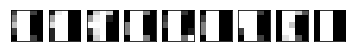

In [8]:
y = np.reshape(y, (9,25))
plot_gallery(y, shape=(5, 5))

Feature map 1:

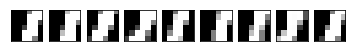

In [9]:
y = vis.get_max_inputs('pool0', 1, 9, x2)
y = np.reshape(y, (9,36))
plot_gallery(y, shape=(6, 6))

In [10]:
y = vis.saliency('pool0', 0, 9, x2)
y.shape

(9, 1, 28, 28)

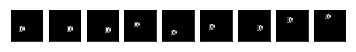

In [11]:
y = np.reshape(abs(y), (9,28*28))
plot_gallery(y, shape=(28, 28))

## Receptive fields of second convolutional layer

In [12]:
w = cnet.conv1.w
b = cnet.conv1.b
w.shape

(40, 20, 5, 5)

In [13]:
y = vis.get_max_inputs('pool1', 0, 9, x2)
y.shape

(9, 1, 16, 16)

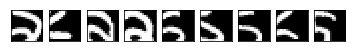

In [14]:
y = np.reshape(y, (9,256))
plot_gallery(y, shape=(16, 16))

In [15]:
y = vis.saliency('pool1', 0, 9, x2)
y.shape

(9, 1, 28, 28)

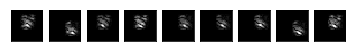

In [16]:
y = np.reshape(abs(y), (9,28*28))
plot_gallery(y, shape=(28, 28))

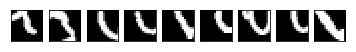

In [17]:
y = vis.get_max_inputs('pool1', 1, 9, x2)
y = np.reshape(y, (9,256))
plot_gallery(y, shape=(16, 16))

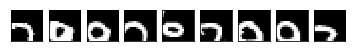

In [18]:
y = vis.get_max_inputs('pool1', 2, 9, x2)
y = np.reshape(y, (9,256))
plot_gallery(y, shape=(16, 16))

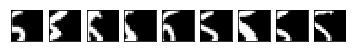

In [19]:
y = vis.get_max_inputs('pool1', 3, 9, x2)
y = np.reshape(y, (9,256))
plot_gallery(y, shape=(16, 16))

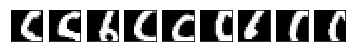

In [20]:
y = vis.get_max_inputs('pool1', 4, 9, x2)
y = np.reshape(y, (9,256))
plot_gallery(y, shape=(16, 16))

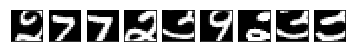

In [21]:
y = vis.get_max_inputs('flatt', 0, 9, x2)
y = np.reshape(y, (9,256))
plot_gallery(y, shape=(16, 16))

## Receptive fields in first linear layer

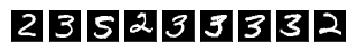

In [22]:
y = vis.get_max_inputs('line0', 0, 9, x2)
y = np.reshape(y, (9,28*28))
plot_gallery(y, shape=(28, 28))

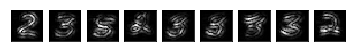

In [25]:
y = vis.saliency('line0', 0, 9, x2, guided_backprop=True)
y = np.reshape(abs(y), (9,28*28))
plot_gallery(y, shape=(28, 28))